In [307]:
import requests
import pandas as pd
import numpy as np
import math
import plotly.express as px 
import matplotlib.pyplot as plt
api_key = "WFHZHJATQIO0HDH7"
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [308]:
def get_stocks(equity):
    base_url = "https://www.alphavantage.co/query?"
    url = base_url + 'function=TIME_SERIES_INTRADAY' + '&symbol=' + equity + '&interval=5min&extended_hours=true&apikey=' + api_key
    response = requests.get(url)
    try:
        if response.status_code == 200:
            df = pd.DataFrame(response.json())
            return df
        else:
            print("Could not fetch data")
            return
    except Exception as e:
        print(f"Error in getting stock data  -  {e}")
        return 

In [309]:
def get_time_series(stocks):
    return stocks[6:]

In [310]:
def plot_stocks(df):
    
    min_close = min(df["Close Price"])
    max_close = max(df["Close Price"])
    tick_vals = list(range(int(min_close // 2) * 2, int(max_close) + 2, 2))
    tick_texts = [str(val) for val in tick_vals]

    fig = px.line(df, x="Time Stamp", y="Close Price", width=1000, height=600)

    fig.update_layout(
        yaxis=dict(
            tickmode='array',
            tickvals=tick_vals,
            ticktext=tick_texts,
            range=[min_close, max_close]
        ),
        title="Stock Prices Over Time"
    )

    fig.show()
    return df


In [311]:
from statsmodels.tsa.stattools import adfuller
def check_for_stationary(df):
    adf_test = adfuller(df)
    return adf_test[1]
    

In [312]:
def differentiate(df_diff):
    df_diff['Close Price'] = df_diff['Close Price'].diff()
    df_diff.dropna(inplace = True)
    return df_diff
    

In [313]:
def get_d(p_value, df):
    d = 0
    while round(p_value,2) > 0.05:
        d += 1
        df = differentiate(df)
        p_value = check_for_stationary(df["Close Price"])
    return d, df
    

In [314]:
import statsmodels.api as sm
import itertools
def get_model(d,df):
    p_values = range(0, 5)
    q_values = range(0, 5)
    
    pq_combinations = list(itertools.product(p_values, q_values))
    
    best_aic = float("inf")
    best_order = None
    
    for p, q in pq_combinations:
        try:
            model = sm.tsa.ARIMA(df, order=(p, d, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, d, q)
        except Exception as e:
            continue
    return model


In [320]:
def forecast(model, df, steps=10):
    forecast_values = model.forecast(steps)  # Forecast next `steps` values

    # Ensure there are no NaNs in the forecasted values
    forecast_values = np.nan_to_num(forecast_values, nan=0.0)  

    # Create future timestamps
    last_timestamp = df.index[-1]  # Get last timestamp in original data
    future_timestamps = pd.date_range(start=last_timestamp, periods=steps + 1, freq='5T')[1:]  # Next `steps` timestamps

    # Create a DataFrame for forecasted values
    forecast_df = pd.DataFrame({"Time Stamp": future_timestamps, "Close Price": forecast_values})

    return forecast_df


In [323]:
import math
import json

def main():
    # equity = input("Enter equity id: ")
    # raw_stocks = get_stocks(equity.upper())
    with open("stock_data.json", "r") as file:
        stock_data = json.load(file)
    raw_stocks = pd.DataFrame(stock_data)
    time_series = get_time_series(raw_stocks)
    stock_data = time_series["Time Series (5min)"][::-1]
    time_stamp = stock_data.index
    close = [float(i["4. close"]) for i in stock_data]
    OG_df = pd.DataFrame({"Time Stamp": time_stamp, "Close Price": close})
    plot_stocks(OG_df)  # Plot the original DataFrame
    df = OG_df.copy()  # Ensure df is separate from OG_df
    p_value = check_for_stationary(df["Close Price"])
    d, df_diff = get_d(p_value, df)  # Ensure get_d() doesn't modify df in place
    model = get_model(d, df_diff['Close Price'])
    future_forecast = forecast(model,OG_df,steps = 10)
    plot_stocks(future_forecast)
    

    
    
        
        

## Top 20 Most Famous Equities

| Equity Name          | Symbol | Sentiment |
|----------------------|--------|-----------|
| Apple Inc.          | AAPL   | Positive  |
| Microsoft Corp.     | MSFT   | Positive  |
| Amazon.com Inc.     | AMZN   | Positive  |
| Alphabet Inc. (GOOGL)| GOOGL | Positive  |
| Alphabet Inc. (GOOG) | GOOG  | Positive  |
| Tesla Inc.          | TSLA   | Negative  |
| Meta Platforms Inc. | META   | Positive  |
| NVIDIA Corp.        | NVDA   | Positive  |
| Berkshire Hathaway  | BRK.B  | Positive  |
| JPMorgan Chase & Co.| JPM    | Positive  |
| Johnson & Johnson   | JNJ    | Negative  |
| Visa Inc.          | V      | Positive  |
| Procter & Gamble   | PG     | Positive  |
| UnitedHealth Group | UNH    | Negative  |
| Exxon Mobil Corp.  | XOM    | Negative  |
| The Walt Disney Co.| DIS    | Positive  |
| Netflix Inc.       | NFLX   | Positive  |
| Adobe Inc.         | ADBE   | Positive  |
| PayPal Holdings Inc

.ased on market trends._


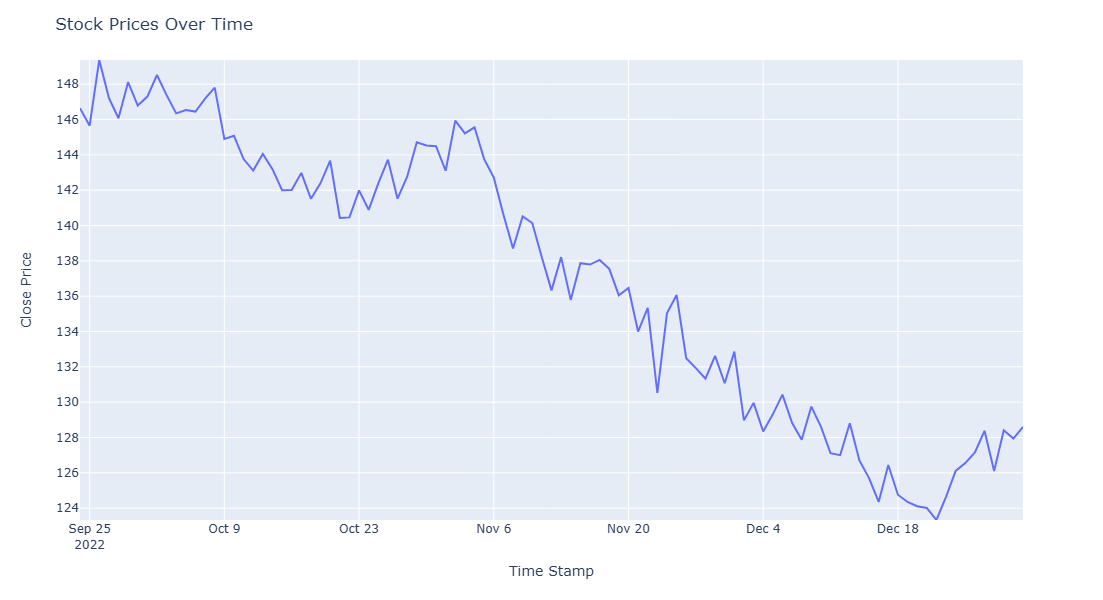

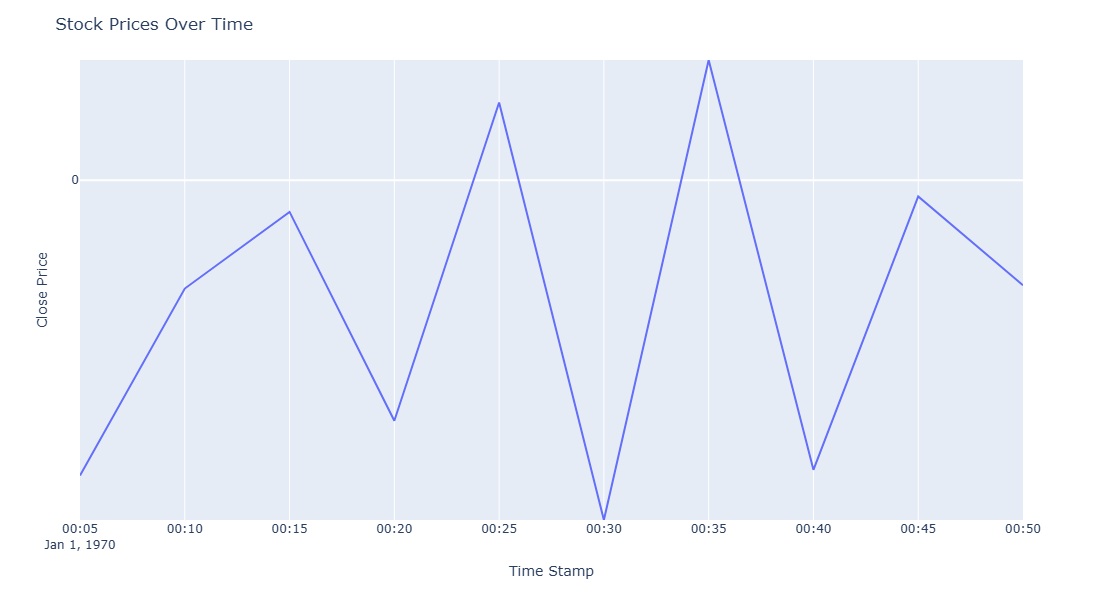

In [324]:
main()